In [ ]:
plot_factor = 1
figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
signal_matrix_space_normal_to_plot = signal_matrix_time_dt_normal.copy()
nx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
nt_linearized = np.linspace(min_nt, max_nt, nb_nt_points)
signal_matrix_space_normal_to_plot['nx'] = nx_linearized
end_frame = 124
start_frame = 5
delta_t = 8
chi_threshold = 17
derivative_label = 'u_t'
#angle = np.round(angle, decimals = 3)
#label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
#title = 'signal ' + quantity + ', '+ label
cmap = cc.cm.CET_L2.reversed()
gradient = np.linspace(0.4,3,int((end_frame - start_frame + 1) / delta_t))
colors = cmap(np.linspace(0,1,int((end_frame  - start_frame + 1) / delta_t)))
signal = signal_matrix_space_normal_to_plot.copy()
signal = signal[(signal['nx']>chi_threshold)]
for (time_frame, line_width, line_color) in zip(range(start_frame,end_frame ,delta_t), gradient, colors):
    plt.plot(signal['nx'], signal.loc[:,time_frame],c = line_color, linewidth = line_width,label = str(np.round(nt_linearized[time_frame],decimals = 1))+'h')
plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
ax.set(xlabel = r'$\chi$', ylabel = r'$ %s \equiv F(\chi|t)$' % derivative_label)
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
#plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
ax.legend(loc='center left', bbox_to_anchor=(0.91, 0.5))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#if FIGURES_DIR != '':
#    plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
plt.show()

In [12]:
import  matplotlib.pyplot as plt
import  pathlib
import  h5py
import pandas as pd
import numpy as np
import warnings
import colorcet as cc
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [14]:
Noise_Proportion    : float = 0.1;

average_window = 5;
average_min_periods = 1;
rolling_average_type = 'gaussian';
sigma_space = 4;
nb_x_points = 252;
nb_t_points = 242;
time_born_change : bool = True;
time_frame_start : int = 30;
time_frame_end : int = 128;


def signal_space_derivative(signal_matrix : pd.DataFrame(),
                            nb_nx_points : int,
                            average_window : int,
                            average_min_periods :int,
                            sigma_space :int,
                            rolling_average_type : str = 'gaussian'):
    signal_matrix_dx = signal_matrix.copy()
    nx_dx = signal_matrix_dx['nx'].iloc[:-1]
    signal_matrix_dx = signal_matrix_dx.diff()
    signal_matrix_dx['nx_delta'] = signal_matrix_dx['nx']*0.5
    for column in signal_matrix_dx.columns:
        signal_matrix_dx.loc[:,column] = signal_matrix_dx.loc[:,column]/signal_matrix_dx.loc[:,'nx']
    signal_matrix_dx.dropna(inplace=True)
    signal_matrix_dx.reset_index(drop=True, inplace=True)
    signal_matrix_dx['nx'] = nx_dx + signal_matrix_dx['nx_delta']
    signal_matrix_dx.drop(['nx_delta'], axis=1, inplace=True)
    min_nx_dx = signal_matrix_dx['nx'].min()
    max_nx_dx = signal_matrix_dx['nx'].max()
    nx_dx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
    signal_matrix_dx_averaged = pd.DataFrame()
    signal_matrix_dx_averaged['nx'] = nx_dx_linearized
    signal_matrix_dx_averaged_temporal = signal_matrix_dx.copy()
    signal_matrix_dx_averaged_temporal.drop(['nx'], axis=1, inplace=True)
    for column in signal_matrix_dx_averaged_temporal.columns:
        ny = np.interp(nx_dx_linearized,signal_matrix_dx['nx'],signal_matrix_dx_averaged_temporal[column])
        signal_matrix_dx_averaged[column] = ny
        signal_matrix_dx_averaged[column] = signal_matrix_dx_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_space)
    signal_matrix_dx_averaged['nx'] = signal_matrix_dx_averaged.loc[:,'nx'].rolling(window = average_window, min_periods = average_min_periods, center=True).mean()
    signal_matrix_dx_averaged = signal_x_common_base(signal_matrix_dx_averaged,'nx',
                                                     signal_matrix_dx_averaged['nx'].min(),
                                                     signal_matrix_dx_averaged['nx'].max(),
                                                     nb_nx_points)
    return signal_matrix_dx_averaged

def signal_time_derivative(signal_matrix : pd.DataFrame(),
                           nb_dt_points : int,
                           average_window : int,
                           average_min_periods : int,
                           sigma_time : int,
                           rolling_average_type : str = 'gaussian'):
    # time derivative
    signal_matrix_dt = signal_matrix.copy()
    nt_dt = signal_matrix_dt['nt'].iloc[:-1]
    nt_dt.reset_index(drop=True, inplace=True)
    signal_matrix_dt = signal_matrix_dt.diff()
    signal_matrix_dt['nt_delta'] = signal_matrix_dt['nt'] * 0.5
    for column in signal_matrix_dt.columns:
        signal_matrix_dt.loc[:,column] = signal_matrix_dt.loc[:,column]/signal_matrix_dt.loc[:,'nt']
    signal_matrix_dt.dropna(inplace=True)
    signal_matrix_dt.reset_index(drop=True, inplace=True)
    signal_matrix_dt['nt'] = nt_dt + signal_matrix_dt['nt_delta']
    signal_matrix_dt.drop(['nt_delta'], axis=1, inplace=True)
    min_nt_dt = signal_matrix_dt['nt'].min()
    max_nt_dt = signal_matrix_dt['nt'].max()
    nt_dt_linearized = np.linspace(min_nt_dt, max_nt_dt, nb_dt_points)
    signal_matrix_dt_averaged = pd.DataFrame()
    signal_matrix_dt_averaged_temporal = signal_matrix_dt.copy()
    signal_matrix_dt_averaged_temporal.drop(['nt'], axis=1, inplace=True)
    signal_matrix_dt_averaged['nt'] = nt_dt_linearized
    for column in signal_matrix_dt_averaged_temporal.columns:
        ny = np.interp(nt_dt_linearized,signal_matrix_dt['nt'],signal_matrix_dt_averaged_temporal[column])
        signal_matrix_dt_averaged[column] = ny
        signal_matrix_dt_averaged[column] = signal_matrix_dt_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_time)
    signal_matrix_dt_averaged['nt'] = signal_matrix_dt_averaged.loc[:,'nt'].rolling(window = average_window,
                                                                                    min_periods = average_min_periods,
                                                                                    center=True).mean()
    signal_matrix_dt_averaged = signal_x_common_base(signal_matrix_dt_averaged,'nt',
                                                     signal_matrix_dt_averaged['nt'].min(),
                                                     signal_matrix_dt_averaged['nt'].max(),
                                                     nb_dt_points)
    return signal_matrix_dt_averaged

def signal_x_common_base(signal_matrix_space : pd.DataFrame(), ref_coordinates_column : str, min_nx_dx : float, max_nx_dx : float, nb_nx_points : int):
    signal_matrix_interpolated_temporal = signal_matrix_space.copy()
    nx_dx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
    signal_matrix_interpolated = pd.DataFrame()
    signal_matrix_interpolated[ref_coordinates_column] = nx_dx_linearized
    signal_matrix_interpolated_temporal.drop([ref_coordinates_column], axis=1, inplace=True)
    for column in signal_matrix_interpolated_temporal.columns:
        ny = np.interp(nx_dx_linearized, signal_matrix_space[ref_coordinates_column], signal_matrix_interpolated_temporal[column])
        signal_matrix_interpolated[column] = ny
    return signal_matrix_interpolated


def signal_t_common_base(signal_matrix_time : pd.DataFrame(), ref_coordinates_column : str, min_nt_dt : float, max_nt_dt : float, nb_nx_points : int):
    signal_matrix_interpolated_temporal = signal_matrix_time.copy()
    nt_dt_linearized = np.linspace(min_nt_dt, max_nt_dt, nb_nt_points)
    signal_matrix_interpolated = pd.DataFrame()
    signal_matrix_interpolated[ref_coordinates_column] = nt_dt_linearized
    signal_matrix_interpolated_temporal.drop([ref_coordinates_column], axis=1, inplace=True)
    for column in signal_matrix_interpolated_temporal.columns:
        ny = np.interp(nt_dt_linearized, signal_matrix_time[ref_coordinates_column], signal_matrix_interpolated_temporal[column])
        signal_matrix_interpolated[column] = ny
    return signal_matrix_interpolated


def plot_signal_space_derivative_fixed_time(signal_matrix_space : pd.DataFrame(),ref_time_label_df : pd.DataFrame(), quantity : str, derivative_label : str,   angle : float,
                                            start_frame: int, end_frame : int, delta_t : int, chi_threshold : float,
                                            plot_factor : float, ratio : float, axes_limitis_manual = False, y_min_manual = False, y_max_manual = False, FIGURES_DIR = ''):
    figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
    angle = np.round(angle, decimals = 3)
    label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
    title = 'signal ' + quantity + ', '+ label
    cmap = cc.cm.CET_CBTL2
    colors = cmap(np.linspace(0,1,int((end_frame  - start_frame + 1) / delta_t)))
    for time_frame,color in zip(range(start_frame,end_frame ,delta_t),colors):
            frame = 't' + str(time_frame)
            signal = signal_matrix_space.loc[:,signal_matrix_space.columns.str.endswith(frame) | signal_matrix_space.columns.str.contains('nx')].copy()
            signal = signal[(signal['nx']>chi_threshold)]
            plt.plot(signal['nx'], signal[quantity+'_r_avrg_'+ frame],c=color,label = ref_time_label_df.iloc[time_frame]['time_label']+' APF')
    plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
    ax.set(xlabel = r'$\chi$', ylabel = r'$ %s \equiv F(\chi|t)$' % derivative_label)
    if axes_limitis_manual:
        ax.set_ylim(y_min_manual, y_max_manual)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
    plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
    ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
    if FIGURES_DIR != '':
        plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
    plt.show()

def plot_signal_time_derivative_fixed_space(signal_matrix_time : pd.DataFrame(),ref_space_label_df : pd.DataFrame(), quantity : str, derivative_label : str,   angle : float,
                                            start_chi_column: int, end_chi_column : int, delta_chi : int, t_threshold : float,
                                            plot_factor : float, ratio : float, axes_limitis_manual = False, y_min_manual = False, y_max_manual = False, FIGURES_DIR = ''):
    figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
    angle = np.round(angle, decimals = 3)
    label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
    title = 'signal ' + quantity + ', '+ label
    cmap = cc.cm.CET_CBTL2
    colors = cmap(np.linspace(0,1,int((end_chi_column  - start_chi_column + 1) / delta_chi)))
    for chi_column,color in zip(range(start_frame,end_frame ,delta_t),colors):
        signal = signal_matrix_time[(signal_matrix_time['nt']>t_threshold)]
        plt.plot(signal.loc[:,'nt'], signal.loc[:,chi_column],c=color,label = r'%s $\mu$' %str(np.round(ref_space_label_df.loc[chi_column,'nx'],decimals = 1)))
    plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
    ax.set(xlabel = r'$t(hAPF)$', ylabel = r'$ %s \equiv F(t|\chi)$' % derivative_label)
    if axes_limitis_manual:
        ax.set_ylim(y_min_manual, y_max_manual)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
    plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
    ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
    if FIGURES_DIR != '':
        plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
    plt.show()
    
def signal_rebase(matrix : pd.DataFrame(), x_ref : np.array(()), t_ref : np.array(()), nb_x : int, nb_t : int, average_window_characteristics):
    average_window = average_window_characteristics[0];
    average_min_periods = 1;
    rolling_average_type = 'gaussian';
    sigma_space = average_window_characteristics[3];
    matrix_interpolated_temporal = matrix.copy();
    matrix_interpolated_temporal.reset_index(drop=True, inplace=True);
    x_min = x_ref.min();
    x_max = x_ref.max();
    print('x_min:',x_min);
    print('x_max:',x_max);
    t_min = t_ref.min();
    t_max = t_ref.max();
    print('t_min:',x_min);
    print('t_max:',x_max);
    x_new = np.linspace(x_min, x_max, nb_x);
    t_new = np.linspace(t_min, t_max, nb_t);
    matrix_temporal = [];
    for column in range(matrix_interpolated_temporal.columns.size):
        ny = np.interp(x_new, x_ref, matrix_interpolated_temporal[column]);
        matrix_temporal.append(ny);
    matrix_temporal_df = pd.DataFrame(matrix_temporal);
    matrix_temporal_df.rolling(window = average_window,
                               min_periods = average_min_periods,
                               win_type = rolling_average_type).mean(std = sigma_space);
    matrix_temporal = [];
    for column in range(matrix_temporal_df.columns.size):
        ny = np.interp(t_new, t_ref, matrix_temporal_df[column]);
        matrix_temporal.append(ny);
    matrix_new = pd.DataFrame(matrix_temporal);
    matrix_new.rolling(window = average_window,
                       min_periods = average_min_periods,
                       win_type = rolling_average_type).mean(std = sigma_space);
    return x_new, t_new, matrix_new    

In [4]:
#signal_matrix_equilibrated = pd.read_csv('dataset/signal_matrix_equilibrated.csv')
signal_matrix_equilibrated = pd.read_csv('D:/LabIREM/codes/python/morphogenesis/morphogenesis_pde/DeePyMod/examples/dataset/signal_matrix_space_data.csv')
plot_time_label_df = pd.read_csv('D:/LabIREM/codes/python/morphogenesis/morphogenesis_pde/DeePyMod/examples/dataset/plot_time_label_df.csv')

In [7]:
# Load data file.
Data_Set_File_Path = "Data/DataSets/Tr_G_WT_normalized_focused_00_N10_P5000.hdf5"
Data_In_File = h5py.File(Data_Set_File_Path, 'r');
Data_In = {};
Data_In['t'] = Data_In_File["t"][:];
Data_In['x'] = Data_In_File["x"][:];
Data_In['usol'] = Data_In_File["u"][:];
Data_In_File.close();

In [9]:
t_points : np.array = Data_In['t'].reshape(-1).astype(dtype  = np.float32);
x_points : np.array = Data_In['x'].reshape(-1).astype(dtype  = np.float32);
Data_Set : np.array = (np.real(Data_In['usol'])).astype(dtype  = np.float32);

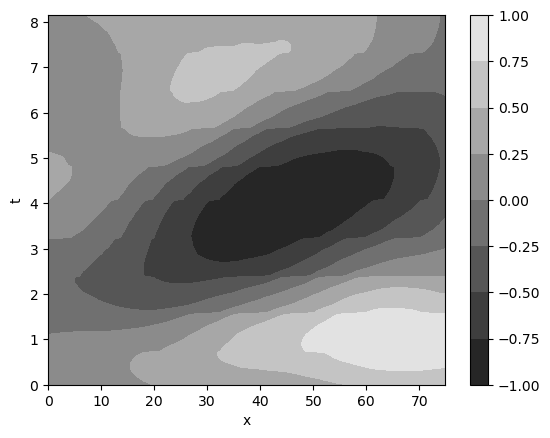

In [13]:
t_to_plot,x_to_plot = np.meshgrid(t_points,x_points);
fig, ax = plt.subplots()
im = ax.contourf(x_to_plot, t_to_plot,Data_Set, cmap=cc.cm.CET_L2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()

In [18]:
signal_matrix_equilibrated = pd.DataFrame(Data_Set)
nb_nx_points = 252;
nb_nt_points = 242;

In [19]:
signal_matrix_equilibrated['nx'] = x_points
signal_matrix_equilibrated_dx = signal_space_derivative(signal_matrix_equilibrated,nb_nx_points,20,1,15)
signal_matrix_equilibrated_dxdx = signal_space_derivative(signal_matrix_equilibrated_dx,nb_nx_points,20,1,15)
signal_matrix_equilibrated_dxdxdx = signal_space_derivative(signal_matrix_equilibrated_dxdx,nb_nx_points,20,1,15)
min_nx_dx = signal_matrix_equilibrated_dxdxdx['nx'].min()
max_nx_dx = signal_matrix_equilibrated_dxdxdx['nx'].max()

signal_matrix_space = signal_x_common_base(signal_matrix_equilibrated,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dx = signal_x_common_base(signal_matrix_equilibrated_dx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dxdx = signal_x_common_base(signal_matrix_equilibrated_dxdx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dxdxdx = signal_x_common_base(signal_matrix_equilibrated_dxdxdx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)

signal_matrix_time = signal_matrix_space.copy()
signal_matrix_time_temporal_nx = signal_matrix_time['nx']
signal_matrix_time.drop(['nx'], axis=1, inplace=True)
signal_matrix_time = signal_matrix_time.T
signal_matrix_time.reset_index(drop=True, inplace=True)
signal_matrix_time['nt'] = t_points

signal_matrix_time_dt = signal_time_derivative(signal_matrix_time,nb_nt_points,20,1,9)
signal_matrix_time_dtdt = signal_time_derivative(signal_matrix_time_dt,nb_nt_points,20,1,9)
min_nt = signal_matrix_time_dtdt['nt'].min()
max_nt = signal_matrix_time_dtdt['nt'].max()


signal_matrix_time_dt = signal_t_common_base(signal_matrix_time_dt, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_time_dt.drop(['nt'], axis=1, inplace=True)
signal_matrix_time_dt_transposed = signal_matrix_time_dt.T
signal_matrix_time_dt_transposed['nx'] = signal_matrix_time_temporal_nx
signal_matrix_time_dt_normal = signal_x_common_base(signal_matrix_time_dt_transposed,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_time_dt_normal.drop(['nx'], axis=1, inplace=True)

In [20]:
print('signal u_t shape')
print(signal_matrix_time_dt_normal.shape)
signal_matrix_space_dx_temporal = signal_matrix_space_dx.copy()
signal_matrix_space_dx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dx_temporal = signal_matrix_space_dx_temporal.T
signal_matrix_space_dx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dx_temporal = signal_t_common_base(signal_matrix_space_dx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dx_normal = signal_matrix_space_dx_temporal.T
print('signal u_x shape')
print(signal_matrix_space_dx_normal.shape)

signal_matrix_space_dxdx_temporal = signal_matrix_space_dxdx.copy()
signal_matrix_space_dxdx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dxdx_temporal = signal_matrix_space_dxdx_temporal.T
signal_matrix_space_dxdx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dxdx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dxdx_temporal = signal_t_common_base(signal_matrix_space_dxdx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dxdx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dxdx_normal = signal_matrix_space_dxdx_temporal.T
print('signal u_xx shape')
print(signal_matrix_space_dxdx_normal.shape)

signal_matrix_space_dxdxdx_temporal = signal_matrix_space_dxdxdx.copy()
signal_matrix_space_dxdxdx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dxdxdx_temporal = signal_matrix_space_dxdxdx_temporal.T
signal_matrix_space_dxdxdx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dxdxdx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dxdxdx_temporal = signal_t_common_base(signal_matrix_space_dxdxdx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dxdxdx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dxdxdx_normal = signal_matrix_space_dxdxdx_temporal.T
print('signal u_xxx shape')
print(signal_matrix_space_dxdxdx_normal.shape)


signal_matrix_space_temporal = signal_matrix_space.copy()
signal_matrix_space_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_temporal = signal_matrix_space_temporal.T
signal_matrix_space_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_temporal = signal_t_common_base(signal_matrix_space_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_normal = signal_matrix_space_temporal.T
print('signal u shape')
print(signal_matrix_space_normal.shape)
signal_matrix_space_square_normal = signal_matrix_space_normal**2
print('signal u^2 shape')
print(signal_matrix_space_normal.shape)

signal u_t shape
(252, 242)
signal u_x shape
(252, 242)
signal u_xx shape
(252, 242)
signal u_xxx shape
(252, 242)
signal u shape
(252, 242)
signal u^2 shape
(252, 242)


In [21]:
'D_t U = -0.138308  + 0.231969(U) + -23.003565(D_x U) + -21.898182(D_x^2 U) + 0.428563(U)(U) + -37.157455(D_x U)(D_x U) + -35.755871(D_x U)(D_x^2 U)'

'D_t U = -0.138308  + 0.231969(U) + -23.003565(D_x U) + -21.898182(D_x^2 U) + 0.428563(U)(U) + -37.157455(D_x U)(D_x U) + -35.755871(D_x U)(D_x^2 U)'

In [24]:
c_0 = -0.138308
c_1 =  0.231969
c_2 = -23.003565
c_3 = -21.898182
c_4 = 0.428563
c_5 = -37.157455
c_6 = -35.755871

In [31]:
signal_matrix_equation_normal = signal_matrix_space_normal * c_1 + \
                                signal_matrix_space_dx_normal * c_2 + \
                                signal_matrix_space_dxdx_normal * c_3 + \
                                signal_matrix_space_square_normal * c_4 + \
                                signal_matrix_space_dx_normal * signal_matrix_space_dx_normal * c_5 + \
                                signal_matrix_space_dx_normal * signal_matrix_space_dxdx_normal*c_6 + c_0

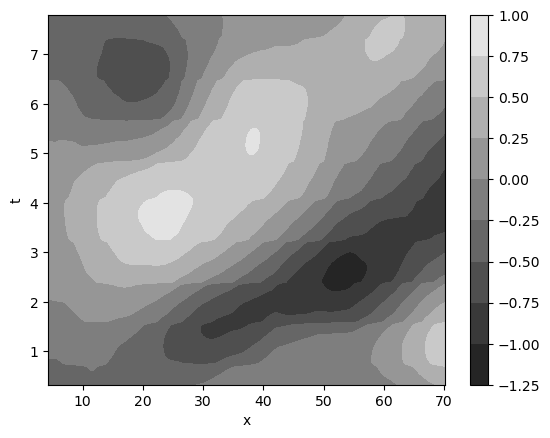

In [32]:
nx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
nt_linearized = np.linspace(min_nt, max_nt, nb_nt_points)
t_to_plot,x_to_plot = np.meshgrid(nt_linearized,signal_matrix_time_temporal_nx);
fig, ax = plt.subplots()
im = ax.contourf(x_to_plot, t_to_plot,signal_matrix_equation_normal, cmap=cc.cm.CET_L2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()

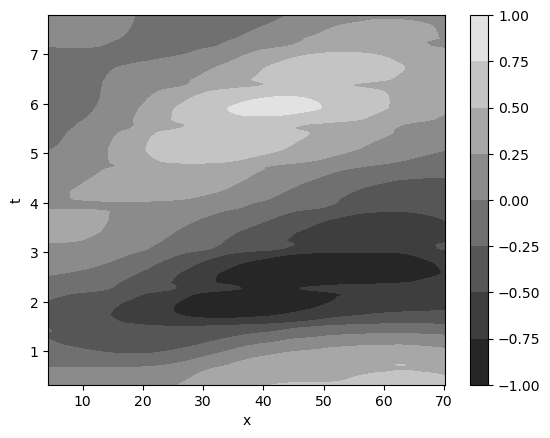

In [33]:
nx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
nt_linearized = np.linspace(min_nt, max_nt, nb_nt_points)
t_to_plot,x_to_plot = np.meshgrid(nt_linearized,signal_matrix_time_temporal_nx);
fig, ax = plt.subplots()
im = ax.contourf(x_to_plot, t_to_plot, signal_matrix_time_dt_normal, cmap=cc.cm.CET_L2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()